<a href="https://colab.research.google.com/github/SolomonHadgu/Composite-Technical-Indicator/blob/main/SOLOMON_HADGU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Title: Develop a composite technical indicator that enhances the predictive accuracy of existing indicators**


**Import libraries**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


**Download Barclays data**

**Download 5-year daily data for Barclays stock market**

In [2]:

ticker = "BARC.L"
data = yf.download(ticker, period="5y", interval="1d")


/tmp/ipython-input-1640678717.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


**Check first five rows**

In [3]:

data.head(5)

Price,Close,High,Low,Open,Volume
Ticker,BARC.L,BARC.L,BARC.L,BARC.L,BARC.L
Date,,,,,
2020-08-07,104.422081,105.400417,102.834789,104.981134,44275008
2020-08-10,106.458618,107.297193,105.160826,106.079267,25747440
2020-08-11,111.569908,112.049087,106.698204,106.837965,39001421
2020-08-12,111.310364,112.747917,110.970946,112.109006,29669867
2020-08-13,107.896172,111.490047,107.896172,110.312054,21609203


**Check last five rows**

In [4]:

data.tail(5)

Price,Close,High,Low,Open,Volume
Ticker,BARC.L,BARC.L,BARC.L,BARC.L,BARC.L
Date,,,,,
2025-08-01,356.620667,370.099569,352.571012,367.619762,31946918
2025-08-04,362.420227,366.069921,359.970416,361.220313,46854272
2025-08-05,360.820343,367.319809,359.455434,367.319809,28505056
2025-08-06,364.869995,366.069909,362.770162,366.069909,64620801
2025-08-07,362.000000,365.549988,360.450012,363.200012,83643941


**Shape of the data**

In [ ]:

data.shape

(1262, 5)

**Check Column names and data types**

In [ ]:

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1262 entries, 2020-08-03 to 2025-08-01
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, BARC.L)   1262 non-null   float64
 1   (High, BARC.L)    1262 non-null   float64
 2   (Low, BARC.L)     1262 non-null   float64
 3   (Open, BARC.L)    1262 non-null   float64
 4   (Volume, BARC.L)  1262 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.2 KB


**Data Descriptive Statistics**

In [ ]:

data.describe()

Price,Close,High,Low,Open,Volume
Ticker,BARC.L,BARC.L,BARC.L,BARC.L,BARC.L
count,1262.000000,1262.000000,1262.000000,1262.000000,1.262000e+03
mean,186.961822,189.421099,184.393449,186.707266,5.012432e+07
std,55.483468,55.946742,54.875264,55.416339,2.933343e+07
min,91.401802,93.957649,88.756086,90.623059,1.549882e+06
25%,150.814957,152.805694,148.422779,150.688500,3.014983e+07
50%,171.687019,174.038400,169.743015,171.801786,4.186462e+07
75%,206.646305,209.084660,204.711026,206.873571,6.115263e+07
max,375.000000,376.350006,370.750000,375.000000,3.090711e+08


**Columns of the data**

In [5]:
print(data.columns)

MultiIndex([( 'Close', 'BARC.L'),
            (  'High', 'BARC.L'),
            (   'Low', 'BARC.L'),
            (  'Open', 'BARC.L'),
            ('Volume', 'BARC.L')],
           names=['Price', 'Ticker'])


**Flatten MultiIndex columns**

In [6]:

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)  # Drop the 'Ticker' level
    data.columns.name = None


**Check final columns**

In [7]:
print("Columns after flattening:", data.columns)

Columns after flattening: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


**Check for Missing Values**

In [8]:

data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


**Remove duplicate timestamps**

In [9]:

data = data[~data.index.duplicated(keep='first')]


**Ensure datetime index**

In [10]:

data.index = pd.to_datetime(data.index)


**Sort data chronologically**

In [11]:

data.sort_index(inplace=True)


**Drop rows with any remaining missing values of Close/Volume**

In [12]:

data = data.dropna(subset=["Close", "Volume"]).copy()


**Time Series Plots**

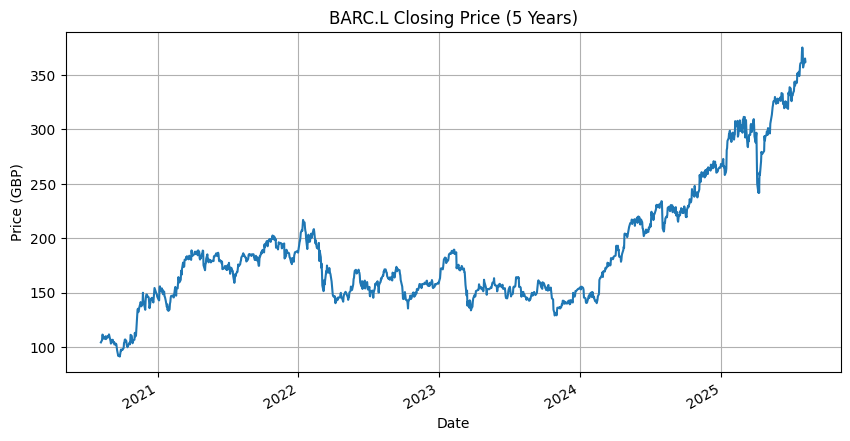

In [13]:
# Visualise price trends and patterns over time.

data['Close'].plot(title='BARC.L Closing Price (5 Years)', figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Price (GBP)')
plt.grid(True)
plt.show()

**Volume Analysis**

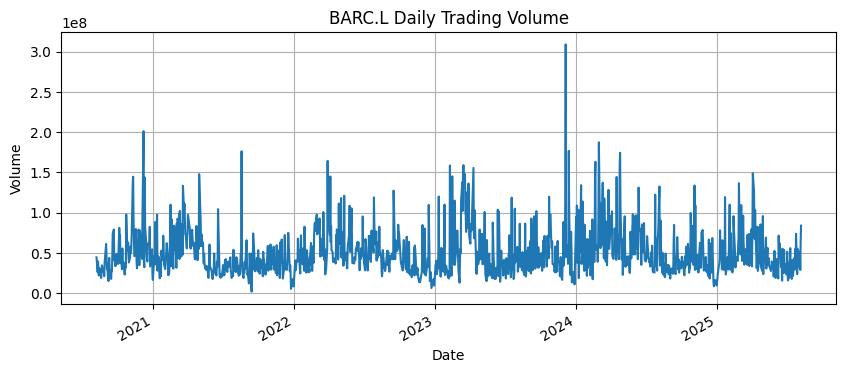

In [14]:
# It spots unusual trading activity

data['Volume'].plot(title='BARC.L Daily Trading Volume', figsize=(10, 4))
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

**Daily Returns**

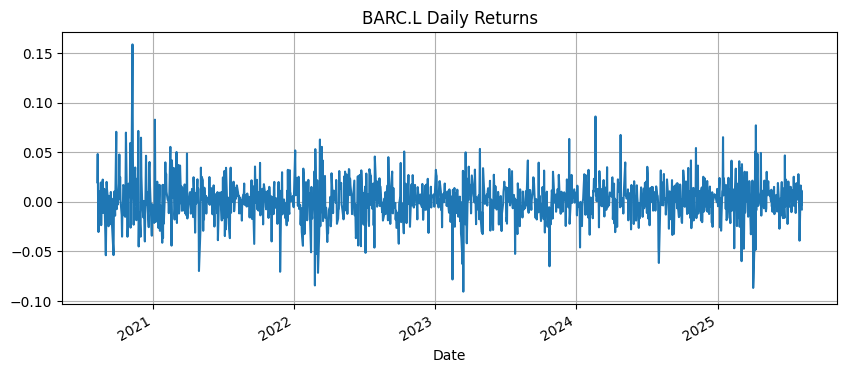

In [15]:
# Examine stock volatility and price change behavior

data['Daily Return'] = data['Close'].pct_change()

data['Daily Return'].plot(title='BARC.L Daily Returns', figsize=(10, 4))
plt.grid(True)
plt.show()

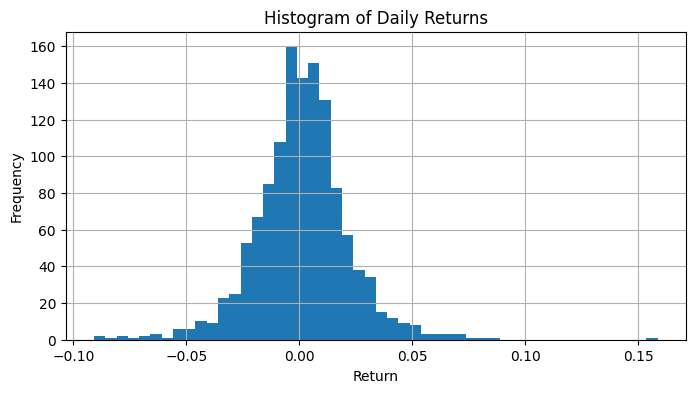

In [16]:
# Daily return Distribution

data['Daily Return'].hist(bins=50, figsize=(8, 4))
plt.title('Histogram of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

**Define and Calculate Individual Technical Indicators**

**1. Momentum Indicator**

**- Used to measure the speed and magnitude of price changes, showing potential overbought or oversold conditions.**

**Relative Strength Index (RSI)**

In [ ]:
# Define RSI Technical Indicator

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    gain_series = pd.Series(gain, index=series.index)
    loss_series = pd.Series(loss, index=series.index)
    avg_gain = gain_series.ewm(alpha=1/window, adjust=False).mean()
    avg_loss = loss_series.ewm(alpha=1/window, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

**2. Trend Indicator**

**- Are widely used to identify the general direction of price movements over different time horizons.**

**Simple Moving Average (SMA)**

In [ ]:
# Define SMA Indicator

def compute_sma(series, window=20):
    return series.rolling(window=window).mean()

**3. Volatility Indicator**

**- They are effective in identifying periods of high or low volatility and highlight potential price extremes**

**Bollinger Bands (BB)**

In [ ]:
# Define BB Indicator

def compute_bollinger_bands(series, window=20, k=2):
    middle = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper = middle + (k * std)
    lower = middle - (k * std)
    width = (upper - lower) / middle
    return middle, upper, lower, width

**4. Volume Indicators**

**- It analyses the flow of trading volume relative to price changes and offers valuable insights into the strength behind price movement.**

**On-Balance Volume (OBV)**

In [ ]:
# Define OBV Indicator

def compute_obv(close, volume):
    obv = [0]
    for i in range(1, len(close)):
        if close.iloc[i] > close.iloc[i - 1]:
            obv.append(obv[-1] + volume.iloc[i])
        elif close.iloc[i] < close.iloc[i - 1]:
            obv.append(obv[-1] - volume.iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=close.index)

**Calculate individual indicators**

In [ ]:

data["RSI"] = compute_rsi(data["Close"])   # RSI

data["SMA"] = compute_sma(data["Close"])   # SMA

bb_middle, bb_upper, bb_lower, bb_width = compute_bollinger_bands(data["Close"])      # BB
data["BB_Middle"] = bb_middle
data["BB_Upper"] = bb_upper
data["BB_Lower"] = bb_lower
data["BBWidth"] = bb_width


data["OBV"] = compute_obv(data["Close"], data["Volume"])         # OBV

print("\n: Indicators Calculated")
print(data[["Close", "RSI", "SMA", "BBWidth", "OBV"]].tail())



: Indicators Calculated
                 Close        RSI         SMA   BBWidth         OBV
Date                                                               
2025-07-28  361.200012  70.014207  343.742500  0.122162  2381103555
2025-07-29  371.200012  75.338514  345.817500  0.134383  2436014528
2025-07-30  375.000000  77.009105  348.280000  0.141700  2470633834
2025-07-31  371.299988  71.901749  350.227499  0.145710  2418403462
2025-08-01  356.649994  56.050812  351.534999  0.135904  2386456544


**Plot Closing Price + SMA**

**- It shows price trends vs. moving average.**

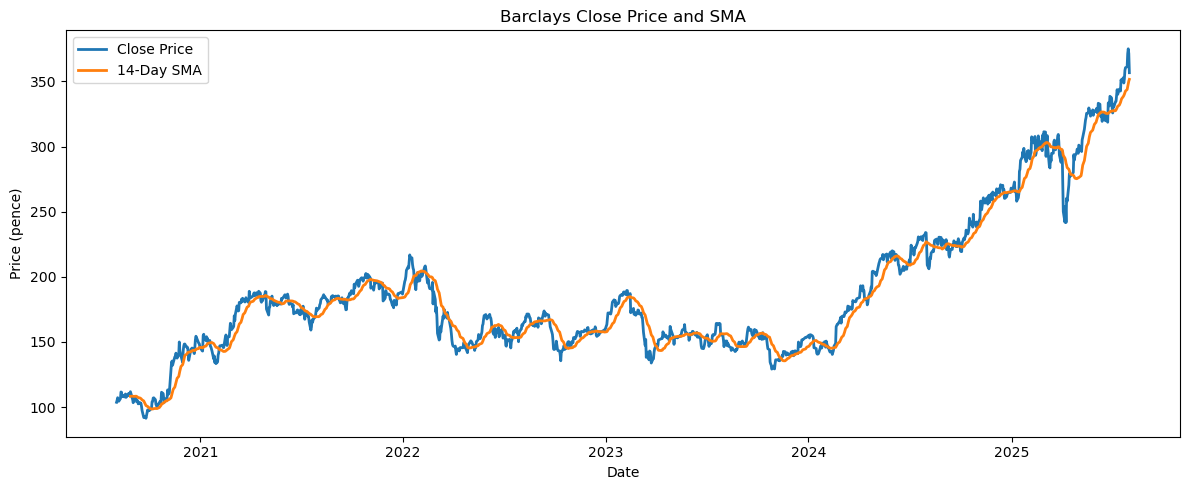

In [ ]:

plt.figure(figsize=(12,5))
plt.plot(data.index, data["Close"], label="Close Price", linewidth=2)
plt.plot(data.index, data["SMA"], label="14-Day SMA", linewidth=2)
plt.title("Barclays Close Price and SMA")
plt.xlabel("Date")
plt.ylabel("Price (pence)")
plt.legend()
plt.tight_layout()
plt.show()


**Plot Relative Strength Index (RSI)**

**- It highlights overbought (>70) and oversold (<30).**

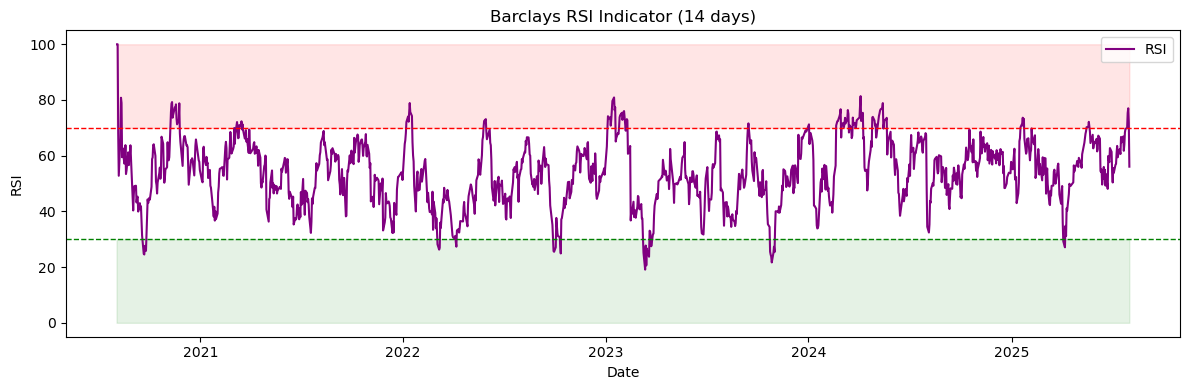

In [ ]:

plt.figure(figsize=(12,4))
plt.plot(data.index, data["RSI"], label="RSI", color='purple')
plt.axhline(70, color='red', linestyle='--', linewidth=1)
plt.axhline(30, color='green', linestyle='--', linewidth=1)
plt.fill_between(data.index, 70, 100, color='red', alpha=0.1)
plt.fill_between(data.index, 0, 30, color='green', alpha=0.1)
plt.title("Barclays RSI Indicator (14 days)")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend()
plt.tight_layout()
plt.show()


**Bollinger Band Width**

**- It visualises volatility over time.**

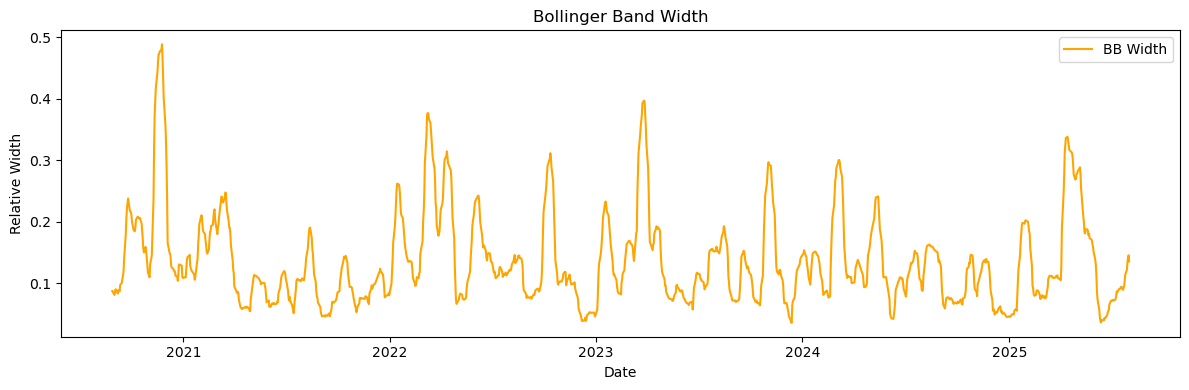

In [ ]:

plt.figure(figsize=(12,4))
plt.plot(data.index, data["BBWidth"], color='orange', label="BB Width")
plt.title("Bollinger Band Width")
plt.xlabel("Date")
plt.ylabel("Relative Width")
plt.legend()
plt.tight_layout()
plt.show()


**Plot OBV vs. Price**

**- It shows how volume trends follow price.**

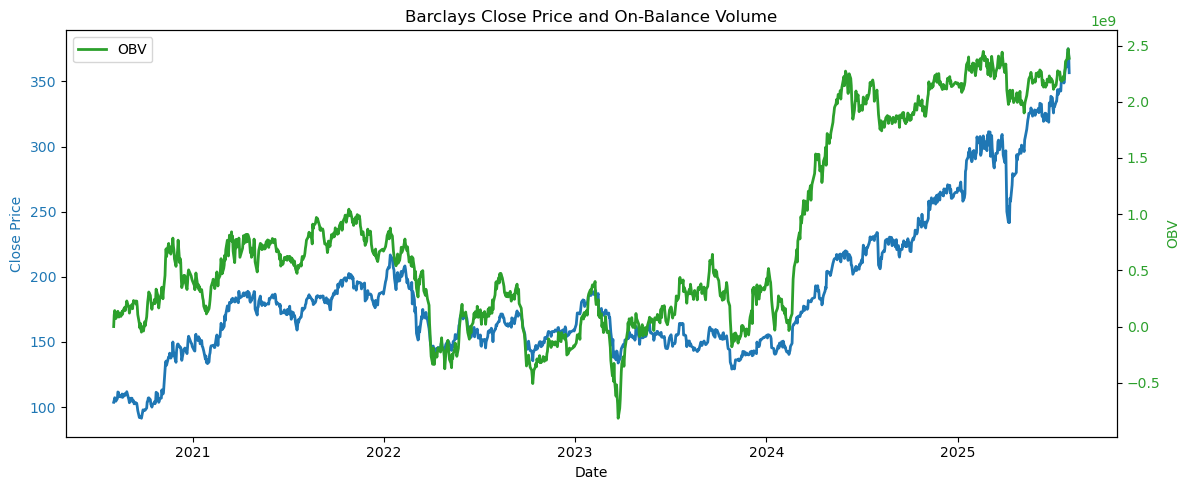

In [ ]:

fig, ax1 = plt.subplots(figsize=(12,5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(data.index, data["Close"], color=color, label="Close Price", linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('OBV', color=color)
ax2.plot(data.index, data["OBV"], color=color, label="OBV", linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Barclays Close Price and On-Balance Volume")
fig.tight_layout()
plt.legend()
plt.show()


**Show correlation between inidcators and price**

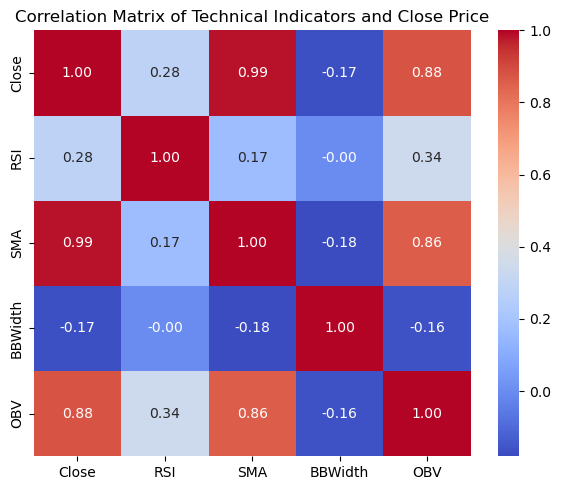

In [ ]:

corr = data[["Close", "RSI", "SMA", "BBWidth", "OBV"]].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Technical Indicators and Close Price")
plt.tight_layout()
plt.show()


**Normalise the Individual Technical Indicators**

**- Scale the indicators between 0 and 1 to make them comparable**

In [ ]:

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = ["RSI", "SMA", "BBWidth", "OBV"]
scaled_cols = [f"{col}_scaled" for col in scaled_features]
data[scaled_cols] = scaler.fit_transform(data[scaled_features])

print("\n: Normalized Individual Technical Indicators")
print(data[scaled_cols].tail())



: Normalized Individual Technical Indicators
            RSI_scaled  SMA_scaled  BBWidth_scaled  OBV_scaled
Date                                                          
2025-07-28    0.629363    0.969205        0.190263    0.972756
2025-07-29    0.695174    0.977405        0.217259    0.989465
2025-07-30    0.715823    0.987137        0.233423    1.000000
2025-07-31    0.652694    0.994833        0.242280    0.984106
2025-08-01    0.456769    1.000000        0.220619    0.974385


**Create Signal for Each Technical Indicator**

**- Create Signals for Each Indicator for binary classification target**

**- Convert each indicator into trading signals (BUY=1, SELL=0, HOLD=0.5)**

In [ ]:

# RSI signal
data["RSI_signal"] = np.where(data["RSI"] < 30, 1, np.where(data["RSI"] > 70, 0, 0.5))

# SMA signal (Close price vs SMA)
data["SMA_signal"] = np.where(data["Close"] > data["SMA"], 1, np.where(data["Close"] < data["SMA"], 0, 0.5))

# BBWidth signal (narrower band = possible breakout)
median_bbwidth = data["BBWidth"].median()
data["BB_signal"] = np.where(data["BBWidth"] < median_bbwidth, 1, 0)

# OBV signal (based on OBV trend)
data["OBV_signal"] = np.where(data["OBV"].diff() > 0, 1, np.where(data["OBV"].diff() < 0, 0, 0.5))

print(": Signals Created")
print(data[["RSI_signal", "SMA_signal", "BB_signal", "OBV_signal"]].head())


: Signals Created
            RSI_signal  SMA_signal  BB_signal  OBV_signal
Date                                                     
2020-08-03         0.5         0.5          0         0.5
2020-08-04         0.0         0.5          0         1.0
2020-08-05         0.0         0.5          0         1.0
2020-08-06         0.5         0.5          0         0.0
2020-08-07         0.5         0.5          0         0.0


**Create Target Variable**

**Define the Actual column to indicate if the price will go up tomorrow**

In [ ]:

data["Actual"] = (data["Close"].shift(-1) > data["Close"]).astype(int)
data.dropna(inplace=True)


**Count Plot of BUY Vs SELL**

**- It summarize how many times a trading strategy generates buy or sell signal over a given period**

C:\Users\test\AppData\Local\Temp\ipykernel_22664\1074255876.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Actual", data=data, palette="coolwarm")


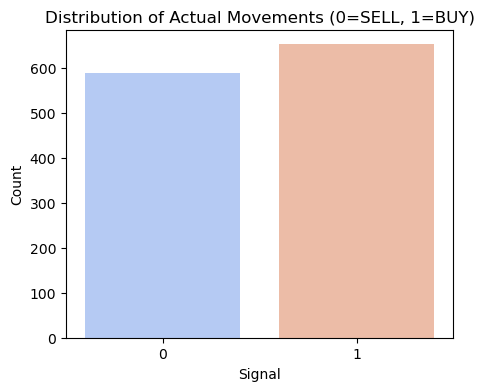

In [ ]:

plt.figure(figsize=(5, 4))
sns.countplot(x="Actual", data=data, palette="coolwarm")
plt.title("Distribution of Actual Movements (0=SELL, 1=BUY)")
plt.xlabel("Signal")
plt.ylabel("Count")
plt.show()


**Overlay BUY/SELL on Price Chart**

**- It is used to visualise entry and exit points on a trading rule**

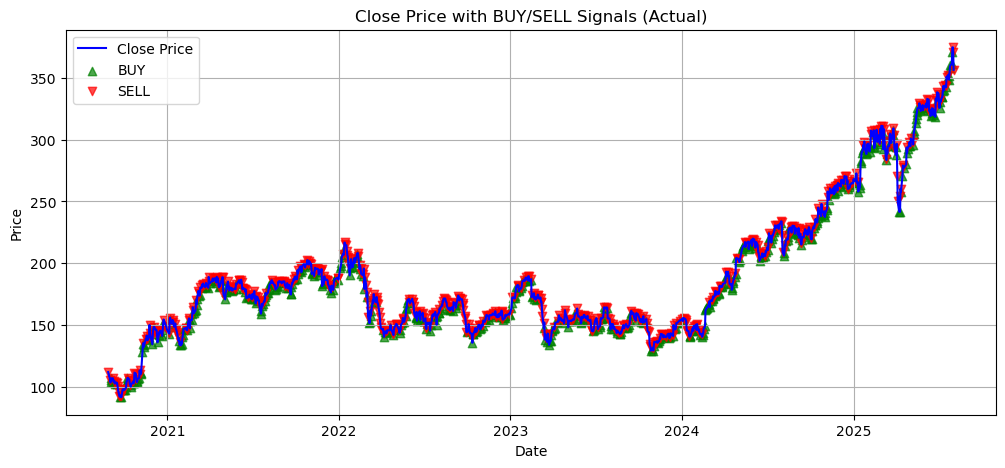

In [ ]:

plt.figure(figsize=(12, 5))
plt.plot(data["Close"], label="Close Price", color="blue")

# Mark BUY (Actual = 1) with green dots
buy_signals = data[data["Actual"] == 1]
plt.scatter(buy_signals.index, buy_signals["Close"], marker="^", color="green", label="BUY", alpha=0.7)

# Mark SELL (Actual = 0) with red dots
sell_signals = data[data["Actual"] == 0]
plt.scatter(sell_signals.index, sell_signals["Close"], marker="v", color="red", label="SELL", alpha=0.7)

plt.title("Close Price with BUY/SELL Signals (Actual)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


**Calculating weights for individual indicators using Logistic Regression**

**- Assign weights to each indicator**

In [ ]:

from sklearn.linear_model import LogisticRegression

X = data[scaled_cols]
y = data["Actual"]

model = LogisticRegression(max_iter=1000)
model.fit(X, y)

coefs = np.abs(model.coef_[0])
weights = coefs / coefs.sum()
w_rsi, w_sma, w_bb, w_obv = weights
print(f"Indicator Weights → RSI={w_rsi:.4f}, SMA={w_sma:.4f}, BBWidth={w_bb:.4f}, OBV={w_obv:.4f}")


Indicator Weights → RSI=0.4136, SMA=0.1000, BBWidth=0.2328, OBV=0.2536


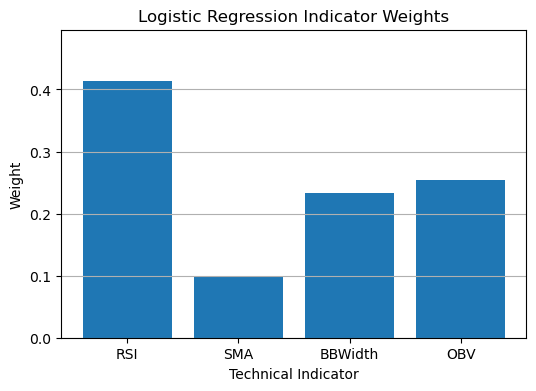

In [ ]:

# Names and weights
indicators = ['RSI', 'SMA', 'BBWidth', 'OBV']
weights = [w_rsi, w_sma, w_bb, w_obv]

# Plot
plt.figure(figsize=(6, 4))
plt.bar(indicators, weights)
plt.title('Logistic Regression Indicator Weights')
plt.ylabel('Weight')
plt.xlabel('Technical Indicator')
plt.grid(True, axis='y')
plt.ylim(0, max(weights) * 1.2)  # Add some space above bars
plt.show()


**Create Composite Technical Indicator (CTI)**

**- It can be created by combining the four scaled technical indicators**

In [ ]:

data["CTI"] = (
    w_rsi * data["RSI_scaled"] +
    w_sma * data["SMA_scaled"] +
    w_bb * data["BBWidth_scaled"] +
    w_obv * data["OBV_scaled"]
)


**Normalise the CTI**

In [ ]:

data["CTI_scaled"] = MinMaxScaler().fit_transform(data[["CTI"]])
data["CTI_signal"] = np.where(data["CTI_scaled"] > 0.6, 1, np.where(data["CTI_scaled"] < 0.4, 0, 0.5))


**BUY/SELL SIGNAL**

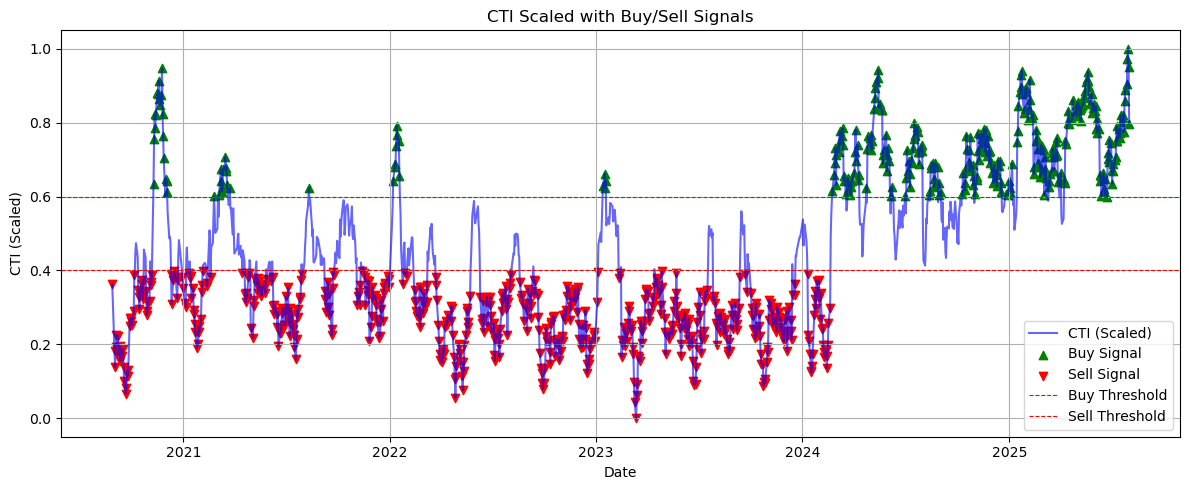

In [ ]:

# Filter signal points
buy_signals = data[data["CTI_signal"] == 1]
sell_signals = data[data["CTI_signal"] == 0]

# Plot CTI_scaled
plt.figure(figsize=(12, 5))
plt.plot(data.index, data["CTI_scaled"], label="CTI (Scaled)", color="blue", alpha=0.6)

# Plot buy signals (CTI_scaled > 0.6)
plt.scatter(buy_signals.index, buy_signals["CTI_scaled"], label="Buy Signal", marker='^', color='green')

# Plot sell signals (CTI_scaled < 0.4)
plt.scatter(sell_signals.index, sell_signals["CTI_scaled"], label="Sell Signal", marker='v', color='red')

# Threshold lines for reference
plt.axhline(0.6, color='green', linestyle='--', linewidth=0.8, label='Buy Threshold')
plt.axhline(0.4, color='red', linestyle='--', linewidth=0.8, label='Sell Threshold')

plt.title("CTI Scaled with Buy/Sell Signals")
plt.xlabel("Date")
plt.ylabel("CTI (Scaled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Build Machine Learning Algorithms**

**- Two Algorithms will be implemented to forcast and compare the performance of the individual and compotite technical indicators**

**1. Build Long Short Term Memory (LSTM) model**

**- Create Sequences for Each Indicator**
    
**- Each indicator will be reshaped as (samples, time_steps, 1) for LSTM.**

In [ ]:

SEQ_LEN = 50  # 50 days sequence

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Target
y = data["Actual"].values

# RSI sequences
X_rsi, y_rsi = create_sequences(data[["RSI_scaled"]].values, y, SEQ_LEN)

# SMA sequences
X_sma, y_sma = create_sequences(data[["SMA_scaled"]].values, y, SEQ_LEN)

# BBWidth sequences
X_bb, y_bb = create_sequences(data[["BBWidth_scaled"]].values, y, SEQ_LEN)

# OBV sequences
X_obv, y_obv = create_sequences(data[["OBV_scaled"]].values, y, SEQ_LEN)

# CTI sequences
X_cti, y_cti = create_sequences(data[["CTI_scaled"]].values, y, SEQ_LEN)


**Train/Test Split for Each Indicator**

In [ ]:

split = 0.8  # 80% train

split_rsi = int(len(X_rsi) * split)                                # RSI Train/Test split
X_train_rsi, X_test_rsi = X_rsi[:split_rsi], X_rsi[split_rsi:]
y_train_rsi, y_test_rsi = y_rsi[:split_rsi], y_rsi[split_rsi:]

split_sma = int(len(X_sma) * split)                                # SMA Train/Test split
X_train_sma, X_test_sma = X_sma[:split_sma], X_sma[split_sma:]
y_train_sma, y_test_sma = y_sma[:split_sma], y_sma[split_sma:]

split_bb = int(len(X_bb) * split)                                  # BB Train/Test split
X_train_bb, X_test_bb = X_bb[:split_bb], X_bb[split_bb:]
y_train_bb, y_test_bb = y_bb[:split_bb], y_bb[split_bb:]

split_obv = int(len(X_obv) * split)                                # OBV Train/Test split
X_train_obv, X_test_obv = X_obv[:split_obv], X_obv[split_obv:]
y_train_obv, y_test_obv = y_obv[:split_obv], y_obv[split_obv:]

split_cti = int(len(X_cti) * split)                                # CTI Train/Test split
X_train_cti, X_test_cti = X_cti[:split_cti], X_cti[split_cti:]
y_train_cti, y_test_cti = y_cti[:split_cti], y_cti[split_cti:]


**Undersampling to address the LSTM Model dataset imbalance**

In [ ]:

def undersample_balance(X_train, y_train):
    class_0_idx = np.where(y_train == 0)[0]
    class_1_idx = np.where(y_train == 1)[0]

    # Shuffle indices
    np.random.shuffle(class_0_idx)
    np.random.shuffle(class_1_idx)

    # Match class sizes
    min_len = min(len(class_0_idx), len(class_1_idx))
    class_0_sample = class_0_idx[:min_len]
    class_1_sample = class_1_idx[:min_len]

    # Combine and shuffle
    balanced_idx = np.concatenate([class_0_sample, class_1_sample])
    np.random.shuffle(balanced_idx)

    return X_train[balanced_idx], y_train[balanced_idx]


In [ ]:
X_train_rsi, y_train_rsi = undersample_balance(X_train_rsi, y_train_rsi)
X_train_sma, y_train_sma = undersample_balance(X_train_sma, y_train_sma)
X_train_bb, y_train_bb = undersample_balance(X_train_bb, y_train_bb)
X_train_obv, y_train_obv = undersample_balance(X_train_obv, y_train_obv)
X_train_cti, y_train_cti = undersample_balance(X_train_cti, y_train_cti)

**LSTM Model Builder**

In [ ]:

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


**Train Each Technical Indicator Using LSTM Model**

**LSTM RSI Model**

In [ ]:

from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# RSI model
model_rsi = build_lstm((X_train_rsi.shape[1], X_train_rsi.shape[2]))
model_rsi.fit(X_train_rsi, y_train_rsi, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)


C:\Users\test\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.5351 - loss: 0.7047 - val_accuracy: 0.4241 - val_loss: 0.7016
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5011 - loss: 0.7255 - val_accuracy: 0.5759 - val_loss: 0.6910
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5126 - loss: 0.7022 - val_accuracy: 0.5759 - val_loss: 0.6911
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4874 - loss: 0.6983 - val_accuracy: 0.5759 - val_loss: 0.6896
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5279 - loss: 0.7012 - val_accuracy: 0.5759 - val_loss: 0.6922
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4923 - loss: 0.7061 - val_accuracy: 0.4346 - val_loss: 0.6939
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5191 - loss: 0.7030 - val_accuracy: 0.5759 - val_loss: 0.6902
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4734 - loss: 0.7030 - val_accuracy: 0.5759 - 

**LSTM SMA Model**

In [ ]:

model_sma = build_lstm((X_train_sma.shape[1], X_train_sma.shape[2]))
model_sma.fit(X_train_sma, y_train_sma, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)


C:\Users\test\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.5271 - loss: 0.7165 - val_accuracy: 0.5602 - val_loss: 0.6923
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4922 - loss: 0.7077 - val_accuracy: 0.5759 - val_loss: 0.6906
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4967 - loss: 0.7062 - val_accuracy: 0.5759 - val_loss: 0.6905
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5229 - loss: 0.6980 - val_accuracy: 0.5550 - val_loss: 0.6923
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4812 - loss: 0.7059 - val_accuracy: 0.5759 - val_loss: 0.6928
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5154 - loss: 0.6963 - val_accuracy: 0.5602 - val_loss: 0.6927
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4952 - loss: 0.7012 - val_accuracy: 0.4241 - val_loss: 0.6958
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5319 - loss: 0.6958 - val_accuracy: 0.5759 - v

**LSTM BB Model**

In [ ]:

model_bb = build_lstm((X_train_bb.shape[1], X_train_bb.shape[2]))
model_bb.fit(X_train_bb, y_train_bb, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/50


C:\Users\test\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5051 - loss: 0.7104 - val_accuracy: 0.5812 - val_loss: 0.6927
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5091 - loss: 0.7176 - val_accuracy: 0.5759 - val_loss: 0.6917
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4853 - loss: 0.6980 - val_accuracy: 0.5759 - val_loss: 0.6914
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5275 - loss: 0.7062 - val_accuracy: 0.5759 - val_loss: 0.6914
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4949 - loss: 0.6949 - val_accuracy: 0.4241 - val_loss: 0.6935
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5302 - loss: 0.6932 - val_accuracy: 0.5759 - val_loss: 0.6922
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4863 - loss: 0.7045 - val_accuracy: 0.5759 - val_loss: 0.6920
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5443 - loss: 0.6942 - val_accuracy: 0.5759 - val_loss: 0.

**LSTM OBV Model**

In [ ]:

model_obv = build_lstm((X_train_obv.shape[1], X_train_obv.shape[2]))
model_obv.fit(X_train_obv, y_train_obv, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/50


C:\Users\test\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.5436 - loss: 0.6961 - val_accuracy: 0.5759 - val_loss: 0.6900
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5069 - loss: 0.7124 - val_accuracy: 0.5759 - val_loss: 0.6920
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5230 - loss: 0.7064 - val_accuracy: 0.5759 - val_loss: 0.6921
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5308 - loss: 0.7013 - val_accuracy: 0.5759 - val_loss: 0.6913
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5053 - loss: 0.7054 - val_accuracy: 0.5393 - val_loss: 0.6925
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4993 - loss: 0.7025 - val_accuracy: 0.5759 - val_loss: 0.6910
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4559 - loss: 0.7166 - val_accuracy: 0.4921 - val_loss: 0.6928
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5249 - loss: 0.7016 - val_accuracy: 0.4293 - val_loss: 0

**LSTM CTI Model**

In [ ]:

model_cti = build_lstm((X_train_cti.shape[1], X_train_cti.shape[2]))
model_cti.fit(X_train_cti, y_train_cti, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)


Epoch 1/50


C:\Users\test\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.4906 - loss: 0.7268 - val_accuracy: 0.5759 - val_loss: 0.6891
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4859 - loss: 0.7241 - val_accuracy: 0.4712 - val_loss: 0.6932
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4993 - loss: 0.7036 - val_accuracy: 0.5759 - val_loss: 0.6897
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4880 - loss: 0.7162 - val_accuracy: 0.4241 - val_loss: 0.6959
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5011 - loss: 0.7010 - val_accuracy: 0.5759 - val_loss: 0.6913
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5200 - loss: 0.6989 - val_accuracy: 0.5759 - val_loss: 0.6916
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5158 - loss: 0.6985 - val_accuracy: 0.5759 - val_loss: 0.6904
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5336 - loss: 0.6935 - val_accuracy: 0.4764 - val_loss: 0.

**Classification Model Performance Evaluation for all Technical Indicators**

In [ ]:

def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} LSTM Evaluation:")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)



In [ ]:

evaluate_model(model_rsi, X_test_rsi, y_test_rsi, "RSI")
evaluate_model(model_sma, X_test_sma, y_test_sma, "SMA")
evaluate_model(model_bb, X_test_bb, y_test_bb, "BBWidth")
evaluate_model(model_obv, X_test_obv, y_test_obv, "OBV")
evaluate_model(model_cti, X_test_cti, y_test_cti, "CTI")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

RSI LSTM Evaluation:
Accuracy : 0.5439
F1 Score : 0.7046
Precision: 0.5439
Recall   : 1.0000
Confusion Matrix:
[[  0 109]
 [  0 130]]
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step

SMA LSTM Evaluation:
Accuracy : 0.4561
F1 Score : 0.0000
Precision: 0.0000
Recall   : 0.0000
Confusion Matrix:
[[109   0]
 [130   0]]


C:\Users\test\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

BBWidth LSTM Evaluation:
Accuracy : 0.4770
F1 Score : 0.5421
Precision: 0.5175
Recall   : 0.5692
Confusion Matrix:
[[40 69]
 [56 74]]
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step

OBV LSTM Evaluation:
Accuracy : 0.5439
F1 Score : 0.7046
Precision: 0.5439
Recall   : 1.0000
Confusion Matrix:
[[  0 109]
 [  0 130]]
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

CTI LSTM Evaluation:
Accuracy : 0.5439
F1 Score : 0.7046
Precision: 0.5439
Recall   : 1.0000
Confusion Matrix:
[[  0 109]
 [  0 130]]


**LSTM Box-Plot**

In [ ]:
# Convert Results into a DataFrame

lstm_results = pd.DataFrame({
    "Indicator": ["RSI", "SMA", "BBWidth", "OBV", "CTI"],
    "Accuracy": [0.5439, 0.4770, 0.4561, 0.5439, 0.5439],
    "F1": [0.7046, 0.0000, 0.5421, 0.7046, 0.7046],
    "Precision": [0.5439, 0.0000, 0.5175, 0.5439, 0.5439],
    "Recall": [1.0000, 0.0000, 0.5692, 1.0000, 1.0000]
})



In [ ]:
# Melt the Data for Seaborn

lstm_melted = lstm_results.melt(
    id_vars="Indicator",
    value_vars=["Accuracy", "F1", "Precision", "Recall"],
    var_name="Metric",
    value_name="Score"
)


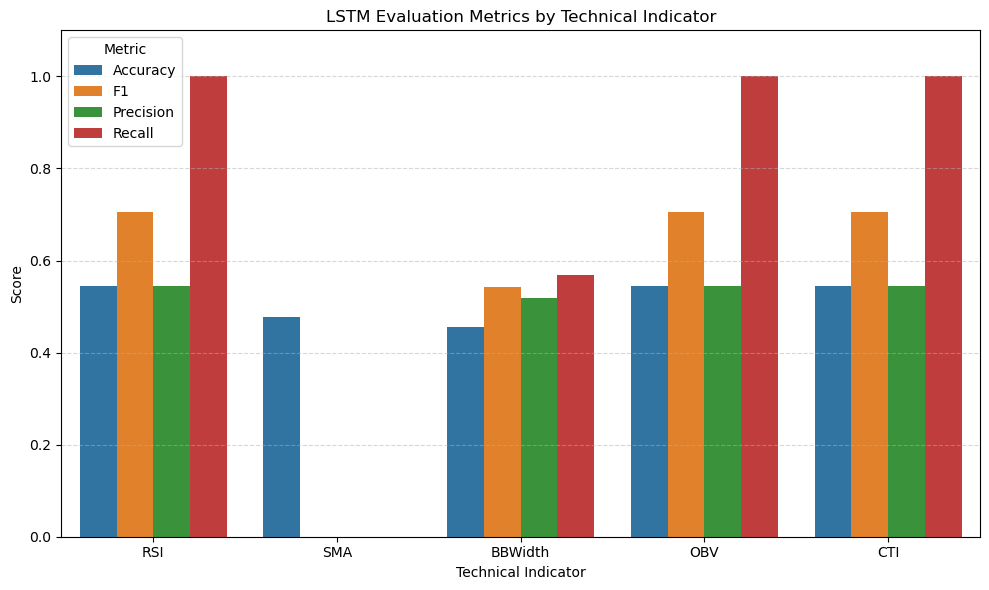

In [ ]:
# Generate the Boxplot

plt.figure(figsize=(10, 6))
sns.barplot(data=lstm_melted, x="Indicator", y="Score", hue="Metric")

plt.title("LSTM Evaluation Metrics by Technical Indicator")
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.xlabel("Technical Indicator")
plt.legend(title="Metric")
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**2. Random forest Algorithm Model**

**Prepare Data for Random Forest**

In [ ]:

# Features

features = ["RSI_scaled", "SMA_scaled", "BBWidth_scaled", "OBV_scaled", "CTI_scaled"]
y = data["Actual"].values


**Train/Test for each Technical Indicators**

In [ ]:

# Split for each indicator

X_rsi = data[["RSI_scaled"]].values
X_train_rsi, X_test_rsi, y_train_rsi, y_test_rsi = train_test_split(X_rsi, y, test_size=0.2, random_state=42, shuffle=False)

X_sma = data[["SMA_scaled"]].values
X_train_sma, X_test_sma, y_train_sma, y_test_sma = train_test_split(X_sma, y, test_size=0.2, random_state=42, shuffle=False)

X_bb = data[["BBWidth_scaled"]].values
X_train_bb, X_test_bb, y_train_bb, y_test_bb = train_test_split(X_bb, y, test_size=0.2, random_state=42, shuffle=False)

X_obv = data[["OBV_scaled"]].values
X_train_obv, X_test_obv, y_train_obv, y_test_obv = train_test_split(X_obv, y, test_size=0.2, random_state=42, shuffle=False)

X_cti = data[["CTI_scaled"]].values
X_train_cti, X_test_cti, y_train_cti, y_test_cti = train_test_split(X_cti, y, test_size=0.2, random_state=42, shuffle=False)


**Build and Train Each Technical Indicator using Random Forest classifier Model**

In [ ]:

from sklearn.ensemble import RandomForestClassifier

# RSI model
rf_rsi = RandomForestClassifier(n_estimators=100, random_state=42)
rf_rsi.fit(X_train_rsi, y_train_rsi)

# SMA model
rf_sma = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sma.fit(X_train_sma, y_train_sma)

# BBWidth model
rf_bb = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bb.fit(X_train_bb, y_train_bb)

# OBV model
rf_obv = RandomForestClassifier(n_estimators=100, random_state=42)
rf_obv.fit(X_train_obv, y_train_obv)

# CTI model
rf_cti = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cti.fit(X_train_cti, y_train_cti)


RandomForestClassifier(random_state=42)

**Model Performance Evaluation function and metrics for all Technical Indicator**

In [ ]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_rf(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Random Forest Evaluation:")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)


**Evaluate All Random Forest Classifier Models**

In [ ]:

evaluate_rf(rf_rsi, X_test_rsi, y_test_rsi, "RSI")
evaluate_rf(rf_sma, X_test_sma, y_test_sma, "SMA")
evaluate_rf(rf_bb, X_test_bb, y_test_bb, "BBWidth")
evaluate_rf(rf_obv, X_test_obv, y_test_obv, "OBV")
evaluate_rf(rf_cti, X_test_cti, y_test_cti, "CTI")



RSI Random Forest Evaluation:
Accuracy : 0.5341
F1 Score : 0.5797
Precision: 0.5755
Recall   : 0.5839
Confusion Matrix:
[[53 59]
 [57 80]]

SMA Random Forest Evaluation:
Accuracy : 0.4819
F1 Score : 0.2543
Precision: 0.6111
Recall   : 0.1606
Confusion Matrix:
[[ 98  14]
 [115  22]]

BBWidth Random Forest Evaluation:
Accuracy : 0.5141
F1 Score : 0.5328
Precision: 0.5656
Recall   : 0.5036
Confusion Matrix:
[[59 53]
 [68 69]]

OBV Random Forest Evaluation:
Accuracy : 0.4940
F1 Score : 0.4425
Precision: 0.5618
Recall   : 0.3650
Confusion Matrix:
[[73 39]
 [87 50]]

CTI Random Forest Evaluation:
Accuracy : 0.5422
F1 Score : 0.5649
Precision: 0.5920
Recall   : 0.5401
Confusion Matrix:
[[61 51]
 [63 74]]


**RF Box-Plot**

In [ ]:
# Create the DataFrame

rf_results = pd.DataFrame({
    "Indicator": ["RSI", "SMA", "BBWidth", "OBV", "CTI"],
    "Accuracy": [0.5341, 0.4819, 0.5141, 0.4940, 0.5422],
    "F1": [0.5797, 0.2543, 0.5328, 0.4425, 0.5649],
    "Precision": [0.5755, 0.6111, 0.5656, 0.5618, 0.5920],
    "Recall": [0.5839, 0.1606, 0.5036, 0.3650, 0.5401]
})


In [ ]:
# Melt for Boxplot

rf_melted = rf_results.melt(
    id_vars="Indicator",
    value_vars=["Accuracy", "F1", "Precision", "Recall"],
    var_name="Metric",
    value_name="Score"
)


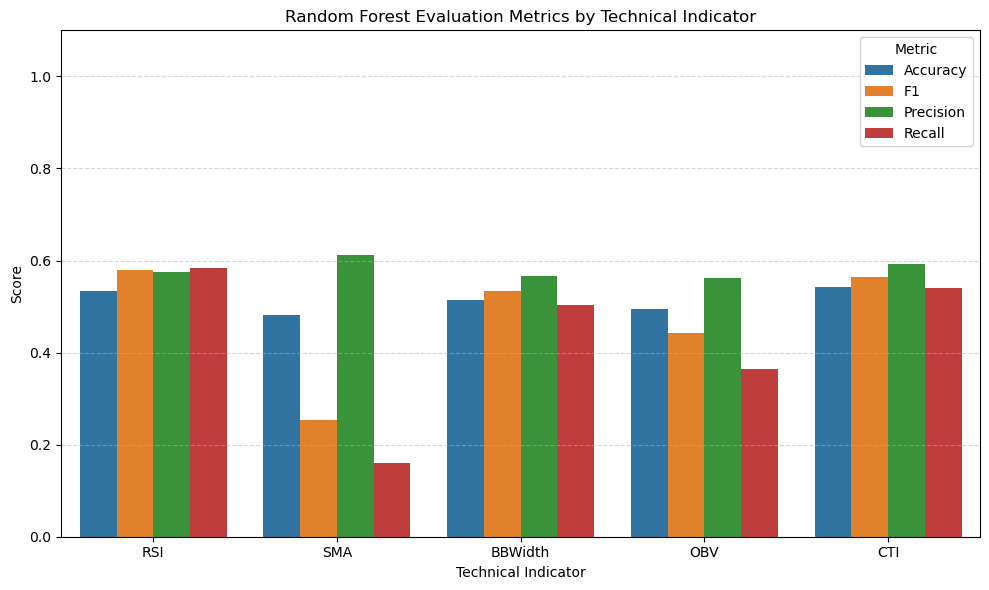

In [ ]:
# Plot as grouped bar chart

plt.figure(figsize=(10, 6))
sns.barplot(data=rf_melted, x="Indicator", y="Score", hue="Metric")

plt.title("Random Forest Evaluation Metrics by Technical Indicator")
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.xlabel("Technical Indicator")
plt.legend(title="Metric")
plt.grid(axis='y', linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**RF Forecast the Next day's price movement**

In [ ]:

# RSI forecast
next_rsi = X_rsi[-1].reshape(1, -1)
next_rsi_prediction = rf_rsi.predict(next_rsi)
print("RSI Model → Next Day Prediction (1=BUY, 0=SELL):", next_rsi_prediction[0])


RSI Model → Next Day Prediction (1=BUY, 0=SELL): 1


In [ ]:

# RSI forecast
next_rsi = X_rsi[-1].reshape(1, -1)
next_rsi_prediction = rf_rsi.predict(next_rsi)

# SMA forcast
next_sma = X_sma[-1].reshape(1, -1)
next_sma_prediction = rf_sma.predict(next_sma)


# BBWidth forcast
next_bb = X_bb[-1].reshape(1, -1)
next_bb_prediction = rf_bb.predict(next_bb)

# OBV Forcast
next_obv = X_obv[-1].reshape(1, -1)
next_obv_prediction = rf_obv.predict(next_obv)

# CTI forcast
next_cti = X_cti[-1].reshape(1, -1)
next_cti_prediction = rf_cti.predict(next_cti)

print("RSI Model → Next Day Prediction (1=BUY, 0=SELL):", next_rsi_prediction[0])
print("SMA Model →", next_sma_prediction[0])
print("BBWidth Model →", next_bb_prediction[0])
print("OBV Model →", next_obv_prediction[0])
print("CTI Model →", next_cti_prediction[0])


RSI Model → Next Day Prediction (1=BUY, 0=SELL): 1
SMA Model → 0
BBWidth Model → 0
OBV Model → 0
CTI Model → 0


**Random Forest Backtest**

**Backtest RF Model for all technical indicators**

In [ ]:

models = {
    "RSI": (rf_rsi, X_test_rsi, data.iloc[-len(X_test_rsi):]["Close"].values),
    "SMA": (rf_sma, X_test_sma, data.iloc[-len(X_test_sma):]["Close"].values),
    "BBWidth": (rf_bb, X_test_bb, data.iloc[-len(X_test_bb):]["Close"].values),
    "OBV": (rf_obv, X_test_obv, data.iloc[-len(X_test_obv):]["Close"].values),
    "CTI": (rf_cti, X_test_cti, data.iloc[-len(X_test_cti):]["Close"].values)
}


RSI Strategy Performance
Initial Capital     : $10000
Final Portfolio     : $10138.01
Total Profit/Loss   : $138.01
Number of Trades    : 53
Average Profit/Trade: $2.60
Win Rate            : 64.15%
Max Drawdown        : -0.22%


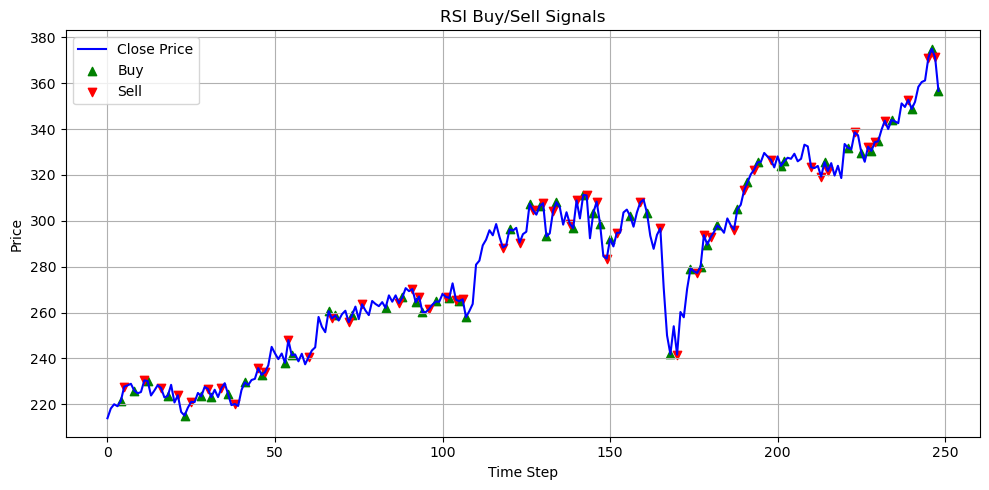

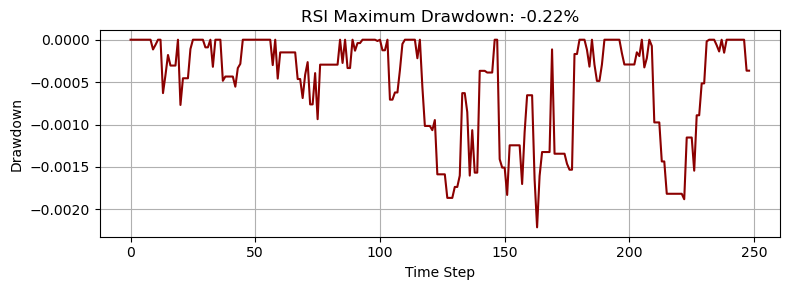


SMA Strategy Performance
Initial Capital     : $10000
Final Portfolio     : $10027.47
Total Profit/Loss   : $27.47
Number of Trades    : 5
Average Profit/Trade: $5.49
Win Rate            : 100.00%
Max Drawdown        : -0.10%


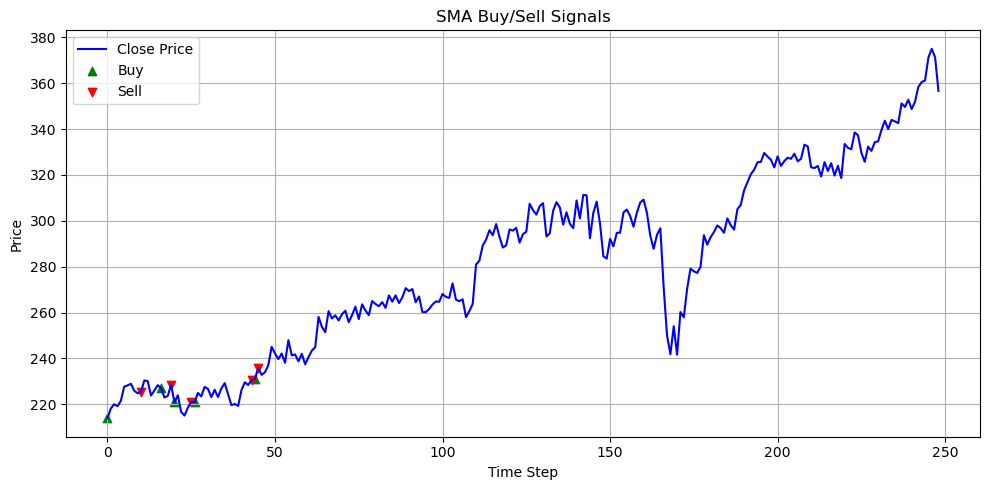

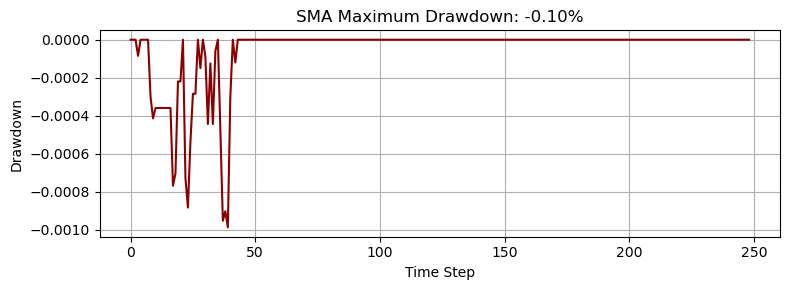


BBWidth Strategy Performance
Initial Capital     : $10000
Final Portfolio     : $10104.22
Total Profit/Loss   : $104.22
Number of Trades    : 58
Average Profit/Trade: $1.80
Win Rate            : 62.07%
Max Drawdown        : -0.35%


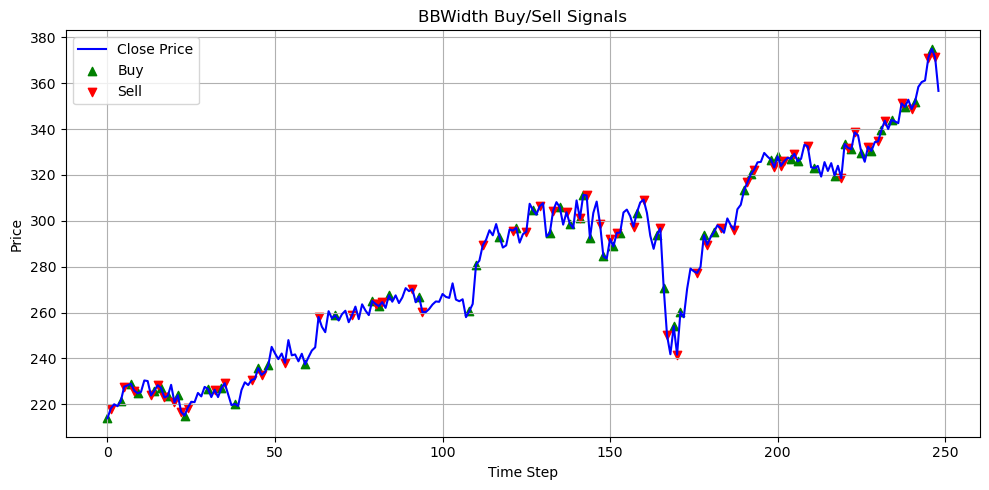

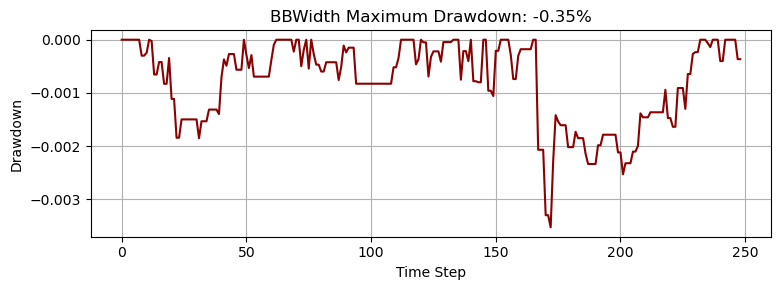


OBV Strategy Performance
Initial Capital     : $10000
Final Portfolio     : $10070.62
Total Profit/Loss   : $70.62
Number of Trades    : 34
Average Profit/Trade: $2.08
Win Rate            : 64.71%
Max Drawdown        : -0.21%


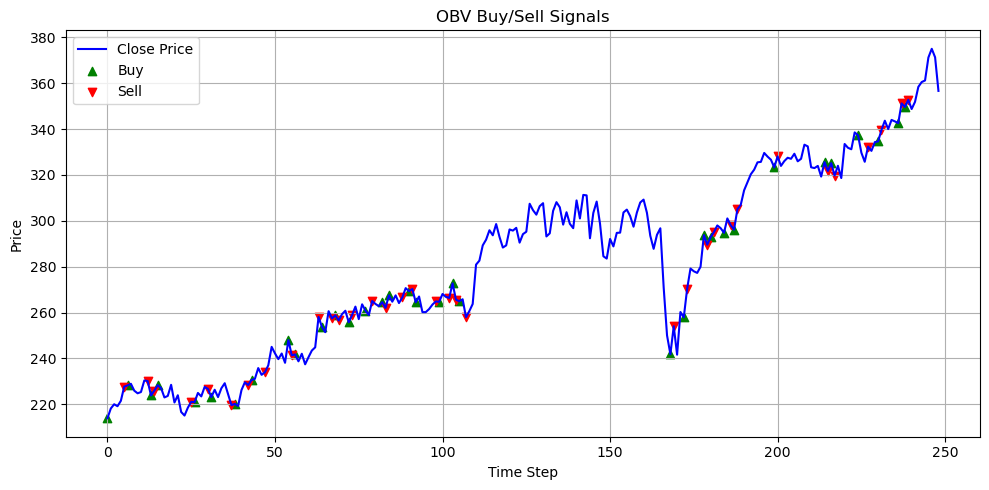

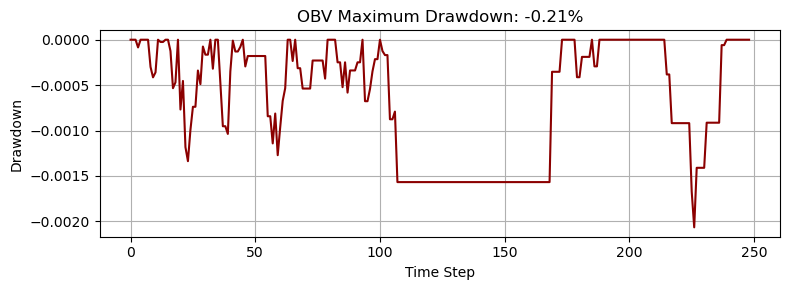


CTI Strategy Performance
Initial Capital     : $10000
Final Portfolio     : $10115.17
Total Profit/Loss   : $115.17
Number of Trades    : 69
Average Profit/Trade: $1.67
Win Rate            : 65.22%
Max Drawdown        : -0.27%


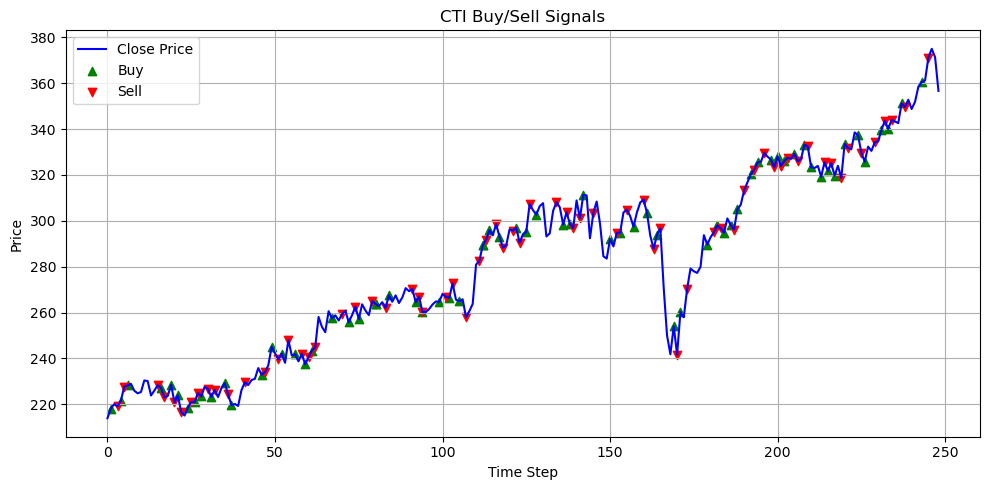

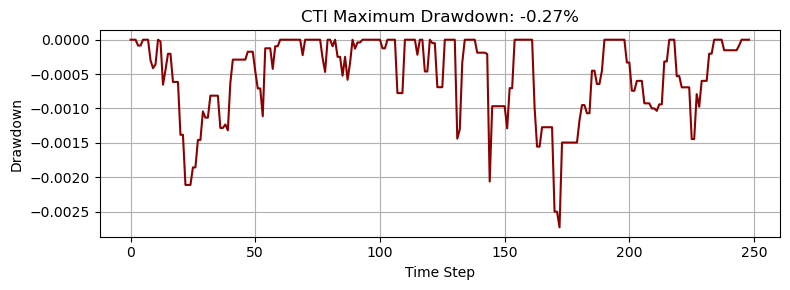

In [ ]:

def backtest_rf_model(name, model, X_test, price_series, initial_capital=10000):
    predicted_signal = model.predict(X_test)
    capital = initial_capital
    holding = False
    portfolio = []
    positions = []

    for i in range(len(predicted_signal)):
        price = price_series[i]
        signal = predicted_signal[i]

        if signal == 1 and not holding:
            entry_price = price
            holding = True
            positions.append({"buy": price})
        elif signal == 0 and holding:
            exit_price = price
            profit = exit_price - entry_price
            capital += profit
            holding = False
            positions[-1]["sell"] = price
            positions[-1]["profit"] = profit


        # Track portfolio value

        portfolio.append(capital if not holding else capital + (price - entry_price))


    # Performance stats

    num_trades = len([p for p in positions if "sell" in p])
    total_profit = capital - initial_capital
    avg_profit = total_profit / num_trades if num_trades else 0
    win_trades = [p for p in positions if p.get("profit", 0) > 0]
    win_rate = len(win_trades) / num_trades if num_trades else 0



    # Max drawdown

    portfolio_series = pd.Series(portfolio)
    running_max = portfolio_series.cummax()
    drawdown = (portfolio_series - running_max) / running_max
    max_drawdown = drawdown.min()

    # Print results

    print(f"\n{name} Strategy Performance")
    print(f"Initial Capital     : ${initial_capital}")
    print(f"Final Portfolio     : ${capital:.2f}")
    print(f"Total Profit/Loss   : ${total_profit:.2f}")
    print(f"Number of Trades    : {num_trades}")
    print(f"Average Profit/Trade: ${avg_profit:.2f}")
    print(f"Win Rate            : {win_rate:.2%}")
    print(f"Max Drawdown        : {max_drawdown:.2%}")


    # Plot buy/sell signals

    plt.figure(figsize=(10, 5))
    plt.plot(price_series, label="Close Price", color="blue")

    buys = [p["buy"] for p in positions if "buy" in p]
    sells = [p["sell"] for p in positions if "sell" in p]
    buy_indices = [list(price_series).index(p["buy"]) for p in positions if "buy" in p]
    sell_indices = [list(price_series).index(p["sell"]) for p in positions if "sell" in p]

    plt.scatter(buy_indices, buys, marker="^", color="green", label="Buy")
    plt.scatter(sell_indices, sells, marker="v", color="red", label="Sell")
    plt.title(f"{name} Buy/Sell Signals")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot drawdown

    plt.figure(figsize=(8, 3))
    drawdown.plot(color="darkred")
    plt.title(f"{name} Maximum Drawdown: {max_drawdown:.2%}")
    plt.ylabel("Drawdown")
    plt.xlabel("Time Step")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for name, (model, X_test, price_series) in models.items():
    backtest_rf_model(name, model, X_test, price_series)
